In [13]:
#%% Preamble

# Modules:
import math
import os
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as sm
from IPython.display import HTML
from matplotlib import cbook, colors
from matplotlib.colors import Normalize

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Class: Normalize cmap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Function: reshape unstacked dataset of results
def ReshapeUnstacked(df):
    # Transpose and reshape:
    df = df.T
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'varname', '0': 'value'}, inplace=True)
    df['index'] = df['varname'].str.startswith('_se')
    df['index'] = df['index'].replace({True: 'se', False: 'beta'})
    df['varname'] = df['varname'].replace({'e(N)': 'e[N]'})
    df['coef'] = df['varname'].str.extract(r'((?<=\[).*(?=\]))', expand=True)
    df = df.pivot(index='coef', columns='index', values='value')
    df.reset_index(inplace=True)
    # Remove N of obs. from rows:
    N = df.at[df.loc[df['coef']=='N'].index[0], 'beta']
    df.drop(df[df.coef=='N'].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Important variables:
zscore = st.norm.ppf(.975) # Note that 1.96 is the zscore inside of which is 95% of the data (ignoring both tails), but st.norm.ppf() gives the zscore which has 95% of the data below it (ignoring only the upper tail).
estsdir = '../estimations'
inputsdir = '../inputs'
Area_labels = ["Business and Administration",
               "Agriculture",
               "Architecture and Art",
               "Natural Sciences",
               "Social Sciences",
               "Law",
               "Education",
               "Humanities",
               "Health",
               "Technology"]

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Target 1a

Stata code:
```stata
statsby _b _se N=e(N) N_clust=e(N_clust), by(tArea) ///
		saving("${taboutdir}/3. RD/Target_1a_w`window'_s`set'_v`dvar'_g`samp'", replace): ///
	   	reg `dvar' ib2010.year ///
	   	admit adif bdif ///
	   	if `window'==1 & `samp'==1  & `set'==1 , cluster(${rutname})
```

Below we plot estimated coefficients of `admit` over target Area (`tArea`), by sample (ie. `Close` and `VeryClose`).

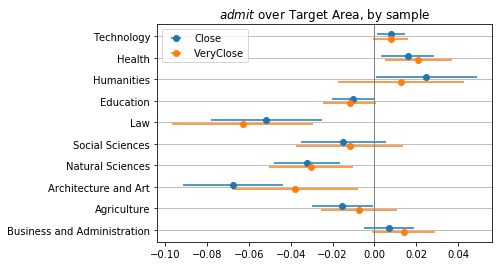

In [16]:
#%% Plot admit coefficient by sample
for idx,samp in enumerate(['Close', 'VeryClose']):
    # Read data and import dict of variable labels:
    dta = os.path.join(estsdir, 'Target_1a_wSample'+samp+'RD_sAll_vltotinc_tc_gAll.dta')
    reader = pd.io.stata.StataReader(dta)
    with reader as f:
        labs = f.variable_labels()
    # Replace empty values in labs dict with original varname
    for key, value in labs.items():
        if not value:
            labs.update({key: key})
    # Create dataframe and apply value labels
    df = pd.read_stata(dta)
    df = df.rename(index=str, columns=labs)
    reader.close()
    # Plot admit coefficients over target Area, by Sample
    y = df.index.astype(float) + 0.1 - 0.2*idx 
    plt.errorbar(df['_b[admit]'], y, xerr=df['_se[admit]'], marker='o', ls='none', label=samp)
    plt.axvline(x=0, linewidth=1, color='grey')
    plt.yticks(df.index.astype(float), Area_labels)
    plt.legend()

ax = plt.axes()
ax.yaxis.grid()
plt.title('$admit$ over Target Area, by sample')
plt.show()

## Target 1b

Stata code:
```stata
statsby _b _se N=e(N) N_clust=e(N_clust), by(tArea) ///
		saving("${taboutdir}/3. RD/Target_1b_w`window'_s`set'_v`dvar'_g`samp'", replace): ///
	   	reg `dvar' ib2010.year ///
	   	adif bdif ///
	   	Type_?_x_admit math_x_admit math2_x_admit read_x_admit read2_x_admit  exp_x_admit exp2_x_admit ///
			ib4.Type  math math2 read read2  exp exp2 ///
	   	if `window'==1 & `samp'==1  & `set'==1 , cluster(${rutname})
```

Below we plot estimated coefficients for `admit` $\cdot$ `i.Type` over target Area (`tArea`), by sample (ie. `Close` and `VeryClose`).
Types are:
- `1.Type`: male, private school
- `2.Type`: male, public school
- `3.Type`: female, private school
- `4.Type`: female, public school

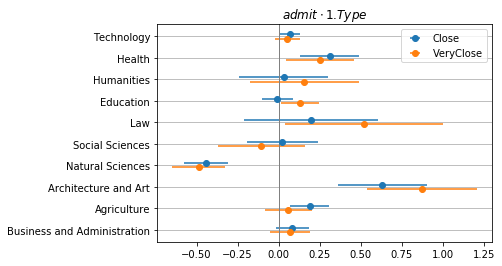

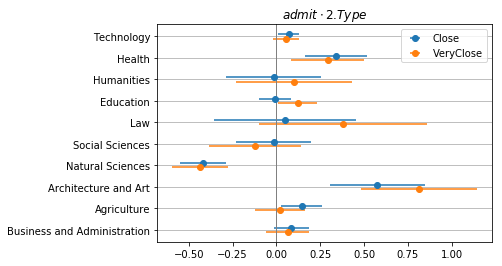

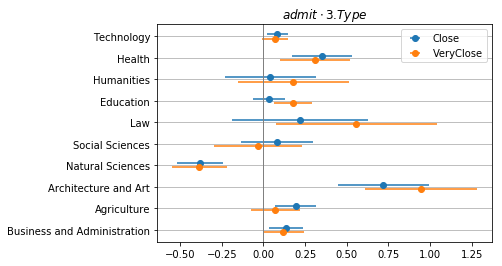

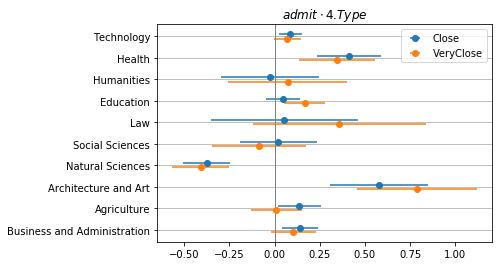

In [17]:
#%% Plot admit coefficient by sample
for type in range(1,5):
    for idx,samp in enumerate(['Close', 'VeryClose']):
        # Read data and import dict of variable labels:
        dta = os.path.join(estsdir, 'Target_1b_wSample'+samp+'RD_sAll_vltotinc_tc_gAll.dta')
        reader = pd.io.stata.StataReader(dta)
        with reader as f:
            labs = f.variable_labels()
        # Replace empty values in labs dict with original varname
        for key, value in labs.items():
            if not value:
                labs.update({key: key})
        # Create dataframe and apply value labels
        df = pd.read_stata(dta)
        df = df.rename(index=str, columns=labs)
        reader.close()
        # Plot admit coefficients over target Area, by Sample
        y = df.index.astype(float) + 0.1 - 0.2*idx
        plt.errorbar(df['_b[Type_'+str(type)+'_x_admit]'], y, xerr=df['_se[Type_'+str(type)+'_x_admit]'], marker='o', ls='none', label=samp)
        plt.axvline(x=0, linewidth=1, color='grey')
        plt.yticks(df.index.astype(float), Area_labels)
        plt.legend()
    plt.title(r'$admit \cdot $'+str(type)+'.$Type$')
    ax = plt.axes()
    ax.yaxis.grid()
    plt.show()
    plt.close()

Below we plot estimated coefficients for `admit` $\cdot$ {`math`, `read`, `exp`} over target Area (`tArea`), by sample (ie. `Close` and `VeryClose`).

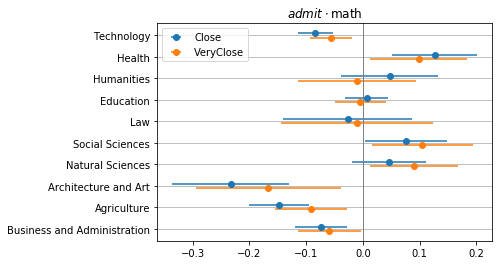

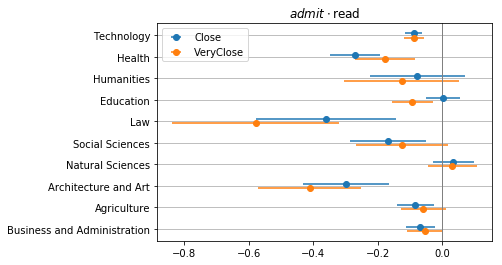

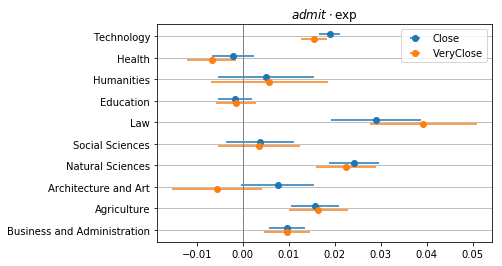

In [15]:
#%% Plot admit coefficient by sample
for coef in ['math', 'read', 'exp']:
    for idx,samp in enumerate(['Close', 'VeryClose']):
        # Read data and import dict of variable labels:
        dta = os.path.join(estsdir, 'Target_1b_wSample'+samp+'RD_sAll_vltotinc_tc_gAll.dta')
        reader = pd.io.stata.StataReader(dta)
        with reader as f:
            labs = f.variable_labels()
        # Replace empty values in labs dict with original varname
        for key, value in labs.items():
            if not value:
                labs.update({key: key})
        # Create dataframe and apply value labels
        df = pd.read_stata(dta)
        df = df.rename(index=str, columns=labs)
        reader.close()
        # Plot admit coefficients over target Area, by Sample
        y = df.index.astype(float) + 0.1 - 0.2*idx
        plt.errorbar(df['_b['+coef+'_x_admit]'], y, xerr=df['_se['+coef+'_x_admit]'], marker='o', ls='none', label=samp)
        plt.axvline(x=0, linewidth=1, color='grey')
        plt.yticks(df.index.astype(float), Area_labels)
        plt.legend()
    plt.title(r'$admit \cdot $'+coef)
    ax = plt.axes()
    ax.yaxis.grid()
    plt.show()
    plt.close()

## Target 1c

Stata code:
```stata
statsby _b _se N=e(N) N_clust=e(N_clust), by(tArea HasNextOption) ///
		saving("${taboutdir}/3. RD/Target_1c_w`window'_s`set'_v`dvar'_g`samp'", replace): ///
	   	reg `dvar' ib2010.year ///
	   	adif bdif ///
	   	Type_?_x_admit math_x_admit math2_x_admit read_x_admit read2_x_admit  exp_x_admit exp2_x_admit ///
			ib4.Type  math math2 read read2  exp exp2 ///
	   	if `window'==1 & `samp'==1  & `set'==1 , cluster(${rutname})
```

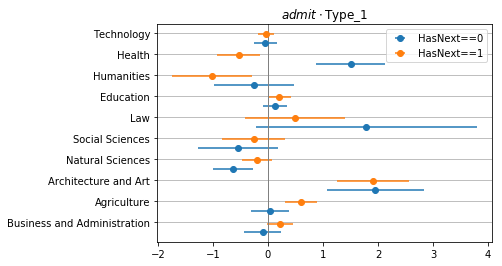

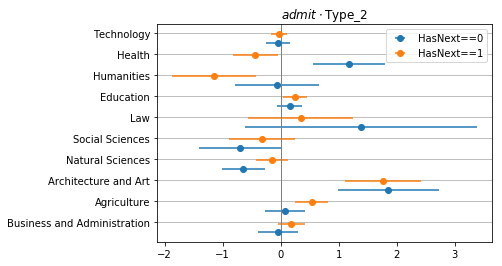

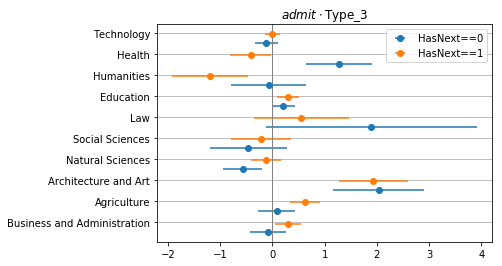

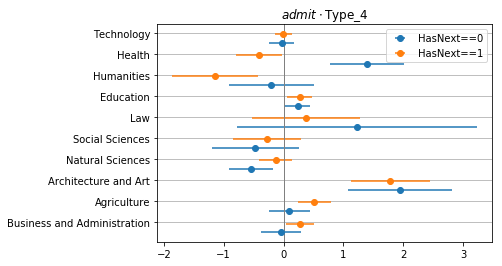

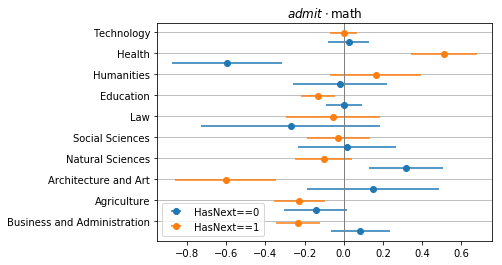

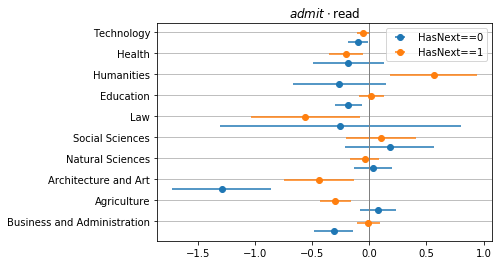

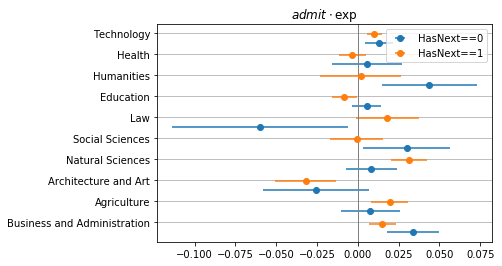

In [21]:
#%% Plot admit coefficient by HasNextOption
for coef in ['Type_1','Type_2','Type_3','Type_4','math', 'read', 'exp']:
    for idx in (0,1):
        # Read data and import dict of variable labels:
        dta = os.path.join(estsdir, 'Target_1c_wSampleVeryCloseRD_sAll_vltotinc_tc_gAll.dta')
        reader = pd.io.stata.StataReader(dta)
        with reader as f:
            labs = f.variable_labels()
        # Replace empty values in labs dict with original varname
        for key, value in labs.items():
            if not value:
                labs.update({key: key})
        # Create dataframe and apply value labels
        df = pd.read_stata(dta)
        df = df.rename(index=str, columns=labs)
        reader.close()
        # Plot admit coefficients over target Area, by Sample
        df = df[df['HasNextOption']==idx]
        y = df.index.astype(float) + 0.1 - 0.2*idx
        plt.errorbar(df['_b['+coef+'_x_admit]'], y, xerr=df['_se['+coef+'_x_admit]'], marker='o', ls='none', label='HasNext=={0}'.format(idx))
        plt.axvline(x=0, linewidth=1, color='grey')
        plt.yticks(df.index.astype(float), Area_labels)
        plt.legend()
    plt.title(r'$admit \cdot $'+coef)
    ax = plt.axes()
    ax.yaxis.grid()
    plt.show()
    plt.close()